# Задание

Решить задачу регрессии. Получить максимальную метрику качества (R2, RMSE).

In [314]:
import pandas as pd
import numpy as np
import seaborn as sns

from xgboost import XGBRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [315]:
random_state = 1431

## Подготовка данных

In [316]:
df = pd.read_csv('Walmart.csv', parse_dates=['Date'])
df.head(5)

/tmp/ipykernel_17205/807122197.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv('Walmart.csv', parse_dates=['Date'])


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-05-02,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-12-02,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-05-03,1554806.68,0,46.50,2.625,211.350143,8.106


In [317]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [318]:
df['Day'] = df.Date.dt.day.astype(np.uint8)
df['WeekDay'] = df.Date.dt.day_of_week.astype(np.uint8)
df['Month'] = df.Date.dt.month.astype(np.uint8)

df.drop('Date', axis=1, inplace=True)

df.head(5)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,WeekDay,Month
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2,6,5
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2,3,12
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,19,4,2
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,26,4,2
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,3,0,5


## Визуализация данных

<AxesSubplot: xlabel='Store', ylabel='Weekly_Sales'>

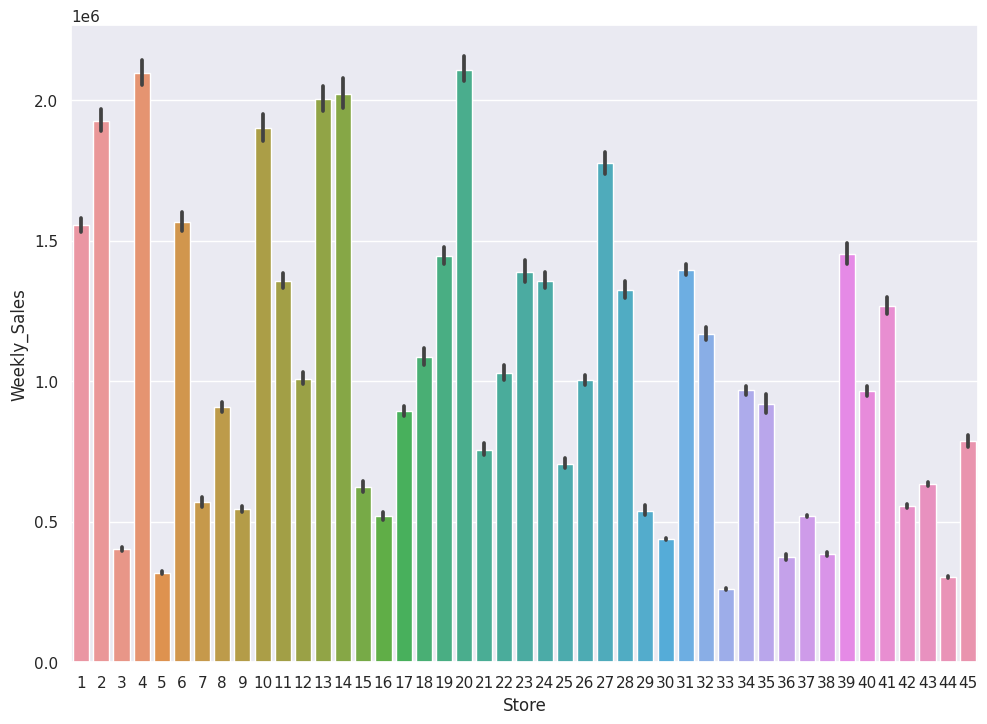

In [319]:
sns.barplot(data=df, x='Store', y='Weekly_Sales')

<AxesSubplot: xlabel='Holiday_Flag', ylabel='Weekly_Sales'>

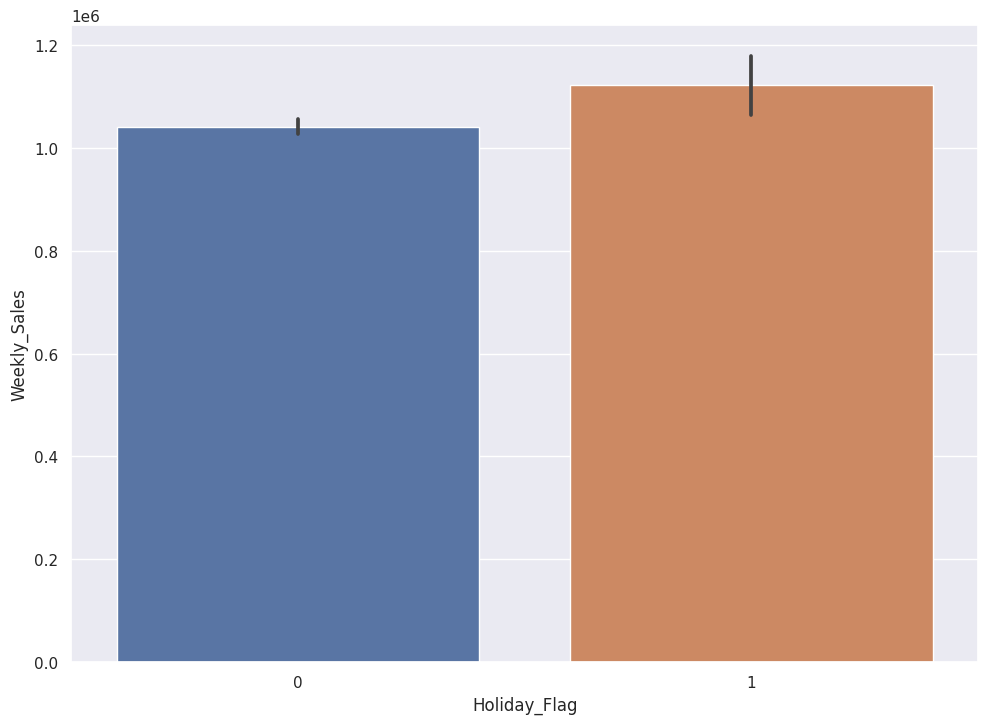

In [320]:
sns.barplot(data=df, x='Holiday_Flag', y='Weekly_Sales')

<AxesSubplot: xlabel='WeekDay', ylabel='Weekly_Sales'>

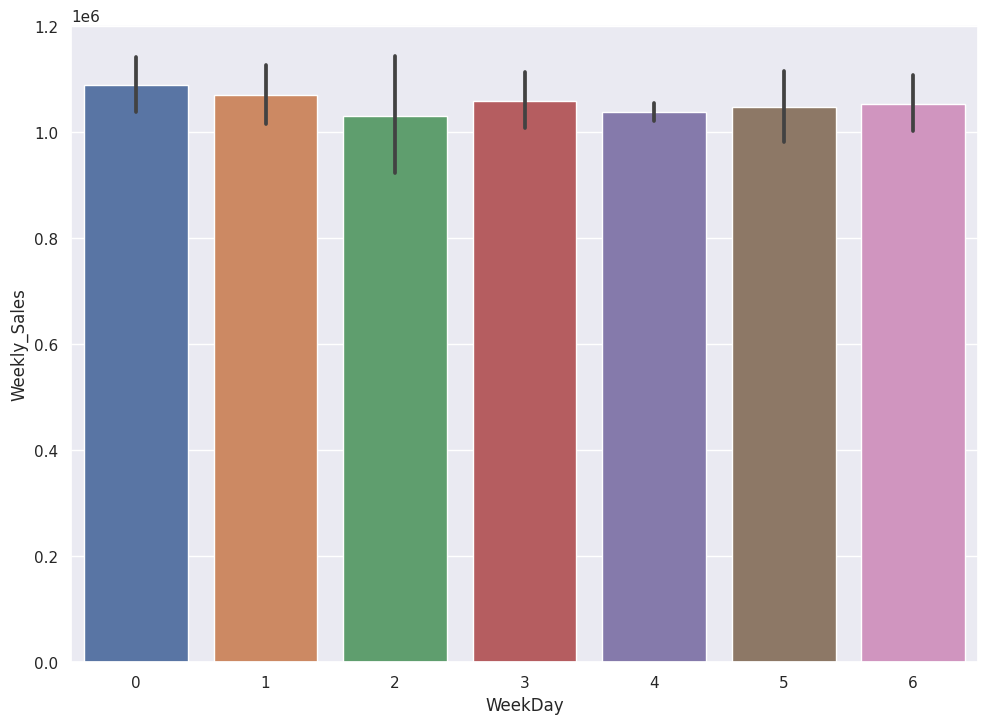

In [321]:
sns.barplot(data=df, x='WeekDay', y='Weekly_Sales')

<AxesSubplot: xlabel='Month', ylabel='Weekly_Sales'>

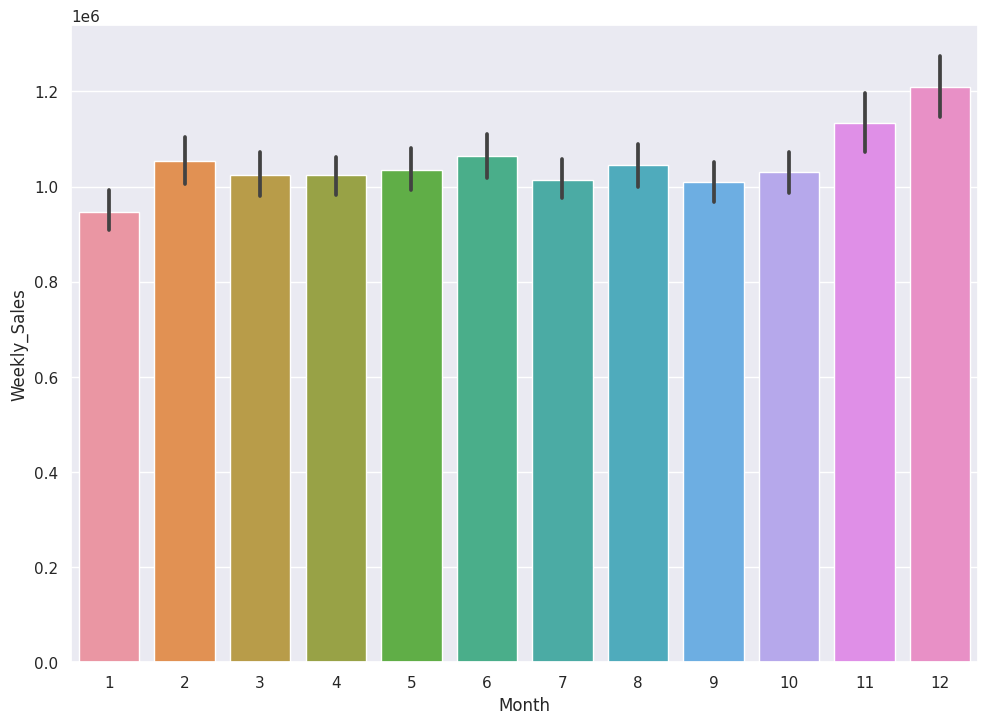

In [322]:
sns.barplot(data=df, x='Month', y='Weekly_Sales')

## Обучение

In [323]:
X = df.drop('Weekly_Sales', axis=1)
y = df.Weekly_Sales

In [324]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_state)

In [325]:
results_df = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'R2'])
def add_to_results(results_df, model_name, predicted):
    series = pd.Series({
        'Model': model_name,
        'MAE': mean_absolute_error(y_test, predicted),
        'RMSE': mean_squared_error(y_test, predicted),
        'R2': r2_score(y_test, predicted)
    })

    return pd.concat([results_df, series.to_frame().T], ignore_index=True)

### LinearRegression

In [326]:
lr = LinearRegression(n_jobs=-1)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
results_df = add_to_results(results_df, 'LinearRegression', y_pred)

### RandomForestRegressor

In [327]:
rf = RandomForestRegressor(n_jobs=-1, random_state=random_state)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
results_df = add_to_results(results_df, 'RandomForestRegressor', y_pred)

### PolynomialFeatures + LinearRegression

In [328]:
pf = make_pipeline(PolynomialFeatures(degree=4), LinearRegression(n_jobs=-1))
pf.fit(X_train, y_train)
y_pred = pf.predict(X_test)
results_df = add_to_results(results_df, 'PolynomialFeatures + LR', y_pred)

### XGBRegressor

In [329]:
xgb = XGBRegressor(n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
results_df = add_to_results(results_df, 'XGBRegressor', y_pred)

In [330]:
results_df

,Model,MAE,RMSE,R2
0,LinearRegression,434538.550823,279859120051.14093,0.128172
1,RandomForestRegressor,65372.680813,15358251353.101955,0.952155
2,PolynomialFeatures + LR,320789.406362,171981738963.547577,0.464236
3,XGBRegressor,53391.528734,8066535734.147551,0.974871


## Выводы

1. Выручка сильно разниться между магазинами
2. Есть характерная зависимость между выручкой и месяцем (в декабре максимум, а в январе минимум)
3. В отдельные дни недели выручка также в среднем выше, чем в другие
4. В праздчиные дни выручка в среднем чуть выше, чем в обычные
5. Наилучшие показетли среди моделей: `XGBRegressor`, `RandomForestRegressor`